CHALLENGE IMA 205 : classification of cardiomyopathic diseases. <br>
Student : Manon Heffernan <br>
Acamedic year : 2022-2023

#Imports


In [ ]:
import os
import numpy as np
import pandas as pd #to read the csv
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from google.colab import files
from sklearn.model_selection import train_test_split
# Standardization/Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import scipy.ndimage as ndi
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt

import torch
import csv
from torch.utils.data import DataLoader
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


print(torch.__version__,"\n", np.__version__,"\n", pd.__version__,"\n", csv.__version__,"\n", nib.__version__)



2.0.0+cu118 
 1.22.4 
 1.5.3 
 1.0 
 3.0.2


Versions : 
torch : 2.0.0+cu118
numpy : 1.22.4
pandas : 1.5.3
csv : 1.0
nibabel : 3.0.2

# Defining global variables
Make sure to properly define the paths to all the different files : the .csv for the training labels, the training and test features files.

In [ ]:
Manon = False

if Manon : 
  from google.colab import drive
  drive.mount('/content/drive')
  my_path = "/content/drive/MyDrive/ima205-challenge-2023/" 

  csv_train_path = my_path+ "metaDataTrain.csv"
  csv_test_path = my_path +"metaDataTest.csv"
  features_train_path = my_path + "features_train_heffernan.txt"
  features_test_path = my_path + "features_test_heffernan.txt"
  # Set the paths to the "train" and "test" folders
  train_path = my_path + "/Train"
  test_path = my_path + "/Test"

  train_and_validation = False #set this variable to True if using a training-validation set
  Test = True #set this variable to True to display the different tests related to the feature computation

else : 
  #if you're using colab, then indicate the path to the different following folders;
  #you also have the option later on to run the classification directly from the features files that I provided.

  my_path = ... #to use if all your data from the challenge is at the same place
  csv_path = ... + "metaDataTrain.csv"
  features_train_path = ... + "features_train_heffernan.txt"
  features_test_path = ... + "features_test_heffernan.txt"
  # Set the paths to the "train" and "test" folders
  train_path = ... + "/Train"
  test_path = ... + "/Test"

  train_and_validation = ... #set this variable to True if using a training-validation set 
  Test = ... #set this variable to True to display the different tests related to the feature computation



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## rename labels
background = 0
right_ventricle = 1
myocardium = 2
left_ventricle = 3

# First tests to get familiar with the data

info for image with id 2 :
 Id            2.0
Category      2.0
Height      160.0
Weight       70.0
Name: 1, dtype: float64
image shape: (216, 256, 10)
[0. 0. 0. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


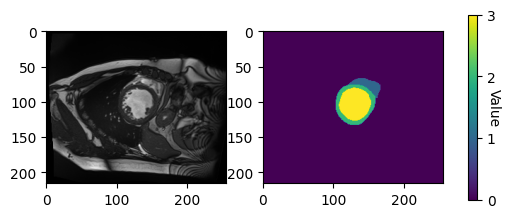

In [ ]:
if Test :
  #Loading classes for each image in training dataset
  train_classes = pd.read_csv(csv_train_path)
  test_classes = pd.read_csv(csv_test_path)
  train_classes.head()
  print("info for image with id 2 :\n",train_classes.loc[1])

  # getting to understand how the data is represented
  seg = nib.load(my_path + '/Train/001/001_ED_seg.nii')
  seg_data=seg.get_fdata()
  print("image shape:",seg.shape)
  seg = np.array(seg_data)[:,:,5]
  print(seg[100, 100:120])

  mri = nib.load(my_path + '/Train/001/001_ED.nii')
  mri_data=mri.get_fdata()
  mri = np.array(mri_data)[:,:,5]

  fig, ax = plt.subplots(1, 2)

  mri_im = ax[0].imshow(mri, cmap="gray")
  seg_im = ax[1].imshow(seg)
  # Add a colorbar next to the image
  cbar = fig.colorbar(seg_im, ax=ax, ticks = [0, 1, 2, 3], shrink = 0.5)
  cbar.ax.set_ylabel('Value', rotation=270)

  # Show the plot
  plt.show()    

# FEATURES COMPUTATION : FUNCTIONS

## VOXEL VOLUME

In [ ]:
def voxel_volume(nib_loaded_seg, label):
  """
  This function computes the voxel volume in `nib_loaded_image` corresponding to the zone with the label `label`.

  Parameters : 
  -------------
  nib_loaded_seg : the image loaded with nib
  label : int

  Returns : 
  -------------
  Float volume in ml.
  """
  img_data=nib_loaded_seg.get_fdata()
  voxel_volume = np.prod(nib_loaded_seg.header.get_zooms()) # Gets the voxel volume in mm³
  # Compute the total number of voxels with correct label in the segmentation image
  num_voxels = np.sum(abs(img_data - label) < 1e-4)
  # Compute the total volume of the zone
  zone_volume = num_voxels * voxel_volume / 1000 #dividing to get the result in ml instead of mm³
  return zone_volume

In [ ]:
if Test :
  seg_ED = nib.load(my_path + '/Train/001/001_ED_seg.nii')
  seg_ES = nib.load(my_path + '/Train/001/001_ES_seg.nii')

  print("The volume of left ventricle in diastole is {:.2f} ml".format(voxel_volume(seg_ED, left_ventricle)))
  print("The volume of right ventricle in diastole is {:.2f} ml".format(voxel_volume(seg_ED, right_ventricle)))

  print("The volume of left ventricle in systole is {:.2f} ml".format(voxel_volume(seg_ES, left_ventricle)))
  print("The volume of right ventricle in systole is {:.2f} ml".format(voxel_volume(seg_ES, right_ventricle)))

### REFERENCES VALUES
According to the table on this [Wikipedia page](https://en.wikipedia.org/w/index.php?title=End-systolic_volume&oldid=1124405560://), here are the standard volume values :


end diastolic volume:
- left ventricle: 142 mL (± 21 mL)
- right ventricle :144 mL (± 23 mL)

end systolic volume:
- left ventricle :	47 mL (± 10 mL)
- right ventricle :50 mL (± 14 mL)

On the previous example, with subject 002, we can see that the results for the left ventricle are way out of norm. And the label associated to this subject is 2, meaning dilated cardiomyopathy.This disease is caracterised by an enlargment of the ventricles (thinning of the wall an stretching), and it starts in the left ventricle ([ref](https://www.heart.org/en/health-topics/cardiomyopathy/what-is-cardiomyopathy-in-adults/dilated-cardiomyopathy-dcm)).

## CARDIAC MUSCLE THICKNESS
Here, I'm just working on one image, to try and compute the maximum muscle thickness. This function will be used later on, on the different images.

In [ ]:
def muscle_thickness(nib_loaded_seg_img) :
  """
  Computes the maximum myocardium thickness

  Parameters : 
  -----------
  `nib_loaded_seg_img` : the segmentation image loaded with nib

  Returns : 
  ----------
  Float thickness
  """
  seg_data = nib_loaded_seg_img.get_fdata()

  # Create a binary mask of the cardiac tissue, aka myocardium (label 2)
  cardiac_mask = (np.abs(seg_data-myocardium) < 1e-4).astype(np.uint8)

  # Dilate the mask to fill gaps and ensure connectivity
  cardiac_mask = binary_dilation(cardiac_mask)

  # Compute the distance transform of the binary mask
  dist_transform = distance_transform_edt(cardiac_mask) #this gets the shortest distance between non-zero values and zero-values

  # Find the maximum value of the distance transform along the axis perpendicular to the heart axis
  axis = 1  #heart axis is the x-axis (axis 1)
  thickness = np.max(np.max(dist_transform, axis=axis)) #this would actually be half the distance, because maximum distance would be for the points in the middle of the muscle wall
  return thickness

In [ ]:
# Load the segmentation image
seg_img = nib.load(my_path + '/Train/001/001_ED_seg.nii')

thickness = muscle_thickness(seg_img)
print("The maximum thickness of the cardiac muscle is roughly 2x{} millimeters".format(thickness))

The maximum thickness of the cardiac muscle is 4.0 millimeters


### REFERENCE VALUES
The myocardium is segmented around the left ventricle. 

-[This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2396316/) indicates 8.6±2.1 mm for end-diastolic thickness.

The training subject 001 has label 2, meaning dilated cardiomyopathy, which is linked to a thinning of the left ventricle wall (aka myocardium). The maximum value is 2$\times$4.0 = 8.0 millimiters, which is in the norm. Since the function I have implemented returns the smallest between the non-zero points and the closest zero points, the highest value would actually be for the points on the midline of the cardiac muscle, but the distance would only be half the full thickness. Therefore, the real medical measure would correspond to twice the distance outputed by my function.

## EJECTION FRACTION

The ejection fraction corresponds to the ratio between the stroke volume and the end-diastolic volume. The stroke volume is the difference between the end-diastolic volume and end-systolic volume.
That is : 
$$ EF = \frac{(EDV - ESV)}{EDV}$$

In [ ]:
def ejection_fraction(EDV, ESV) :
  """
  Computes the ejection fraction

  Parameters : 
  ------------
  `EDV` : end-diastolic volume
  `ESV` : end-systolic volume
  """

  if EDV > 0 :
    return (EDV - ESV)/(EDV)
  else :
    return 0

### REFERENCE VALUES ([source](https://en.wikipedia.org/wiki/Ejection_fraction))
- left ventricle : 66% (± 6%) 	
- right venrticle : 67% (± 4.6%)

# BUILDING THE LISTS OF FEATURES
First round I decided that each subject would have the following features:
1. myocardium thickness,
2. EDV(myocardium),
3. ESV (myocardium),
4. EDV (left ventricle),
5. ESV (left ventricle),
6. EDV (right ventricle), 
7. ESV (right ventricle),
8. Ejection fraction (left ventricle), 
9. Ejection fraction (right ventricle), 
10. ratio between EDV left/EDV right,
11. ratio between ESV left/ESV right,
12. ratio between EDV myocardium/EDV left,
13. ratio between ESV myocardium/ESV left,
14. weight,
15. height.

Those choices are motivated by [this article](https://link.springer.com/chapter/10.1007/978-3-319-75541-0_11), precisely the following extract : <br>
Each patient was described by patient and image characteristics. Patient characteristics were patient weight (in kg) and patient height (in cm). Image characteristics were extracted from the automatically obtained segmentations: LV, RV and myocardial volume at ED and ES (in ml), the LV and RV ejection fraction (EF), the ratio between RV and LV volume at ED and ES, and the ratio between myocardial and LV volume at ED and ES. Hence, 14 features were used in total: 2 patient-based and 12 image-based features.

I've reused all those features and included the maximum thickness of the myocardium.

In [ ]:
def extract_features(path_to_folder, train_set = True):
  """
  Extracts the features from given set (train or test), saves those features in a file.
  Parameters : 
  -------------
  `path_to_folder`:
  `train_set` : boolean
  True if computing the features on the train set.
  False if computing the features on the test set.

  Returns : 
  -------------
  The list of the features, of shape (number_subjects, number_features). The features are also saved in a file so they only need to be computed once.
  """
  if train_set :
    file_name= 'features_train_heffernan.txt'
  else : 
    file_name ='features_test_heffernan.txt'
  with open(file_name, 'w') as f:
    f.truncate(0)
    if train_set:
      features = [[] for i in range(100)]
    else : 
      features = [[] for i in range(50)]
    # Loop through each folder in the "Train" (or "Test") folder
    for folder_name in os.listdir(path_to_folder):
        folder_path = os.path.join(path_to_folder, folder_name)
        if os.path.isdir(folder_path):
            
            # Find the X_ED_seg.nii file in the current folder
            if train_set :
              ED_seg_path = os.path.join(folder_path, f"{folder_name}_ED_seg.nii")
              ES_seg_path = os.path.join(folder_path, f"{folder_name}_ES_seg.nii")
            else :
              ED_seg_path = os.path.join(folder_path, f"{folder_name}_full_ED_seg.nii")
              ES_seg_path = os.path.join(folder_path, f"{folder_name}_full_ES_seg.nii")
            if os.path.isfile(ED_seg_path):
              features_list = []
              n = int(folder_name)
              # Load the image using nibabel
              ED_seg = nib.load(ED_seg_path)
              ES_seg = nib.load(ES_seg_path)
              # compute volumes and thickness
              thickness = muscle_thickness(ED_seg) 
              EDV_myocardium = voxel_volume(ED_seg, myocardium)
              ESV_myocardium = voxel_volume(ES_seg, myocardium)
              EDV_left = voxel_volume(ED_seg, left_ventricle)
              ESV_left = voxel_volume(ES_seg, left_ventricle)
              EDV_right = voxel_volume(ED_seg, right_ventricle)
              ESV_right = voxel_volume(ES_seg, right_ventricle)
                            
              features_list.append(muscle_thickness(ED_seg))
              features_list.append(EDV_myocardium)
              features_list.append(ESV_myocardium)
              features_list.append(EDV_left)
              features_list.append(ESV_left)
              features_list.append(EDV_right)
              features_list.append(ESV_right)
              features_list.append(ejection_fraction(EDV_left, ESV_left))
              features_list.append(ejection_fraction(EDV_right, ESV_right))
              features_list.append(EDV_left/EDV_right) #post-challenge comment : should be the inverse 
              features_list.append(ESV_left/ESV_right) #post-challenge comment : should be the inverse 
              features_list.append(EDV_myocardium/EDV_left)
              features_list.append(ESV_myocardium/ESV_left)
              if train_set :
                features_list.append(train_classes.loc[n-1]['Weight'])
                features_list.append(train_classes.loc[n-1]['Height'])
                features[n-1] = features_list
              else: 
                features_list.append(test_classes.loc[n-101]['Weight'])
                features_list.append(test_classes.loc[n-101]['Height'])
                features[n-101] = features_list
              
    for line in features :    
      f.write(' '.join([str(elem) for elem in line]))
      f.write('\n')
    if train_set :
      files.download('features_train_heffernan.txt')
    else:
      files.download('features_test_heffernan.txt')
    return features



# PREPROCESSING : LEFT VENTRICLE SEGMENTATION
I want to segment the left ventricle on the test set. I'll first try to do this without machine learning : I'm considering the zone inside the myocardium as the left ventricle.

In [ ]:
def segment_left_ventricle(path_to_folder):
  """
  Iterates through the folders in `path_to_folder` to segment the left ventricle from both the XXX_ED_seg.nii and XXX_ES_seg.nii.
  The left ventricle is seen as the zone contained by the myocardium. 
  The full segmentations are saved in the corresponding XXX folder as XXX_ED_seg_full.nii or XXX_ES_seg_full.nii.
  Parameters :
  ------------
  `path_to_folder`:the path to the `Test`folder. For example, "/content/challenge/Test"

  Returns :
  ------------
  None.
  """
  for folder_name in os.listdir(path_to_folder):
          folder_path = os.path.join(path_to_folder, folder_name)
          if os.path.isdir(folder_path):
              # Find the X_ED_seg.nii and ES files in the current folder
              ED_seg_path = os.path.join(folder_path, f"{folder_name}_ED_seg.nii")
              ES_seg_path = os.path.join(folder_path, f"{folder_name}_ES_seg.nii")
              if os.path.isfile(ED_seg_path) and os.path.isfile(ES_seg_path): #to be sure the files are found
                ED_nib = nib.load(ED_seg_path)
                ED_seg = ED_nib.get_fdata()
                ES_nib = nib.load(ES_seg_path)
                ES_seg = ES_nib.get_fdata()
                # creating masks for the myocardium on ED and ES segmentations
                new_ED_seg = ED_seg.copy()
                new_ES_seg = ES_seg.copy()
                new_ED_seg[new_ED_seg != myocardium] = 0
                new_ES_seg[new_ES_seg != myocardium] = 0
                new_ED_seg[new_ED_seg == myocardium] = 1
                new_ES_seg[new_ES_seg == myocardium] = 1
                ES_array = np.zeros(new_ES_seg.shape)
                ED_array = np.zeros(new_ED_seg.shape)
                
                for n in range(new_ED_seg.shape[2]): #diastole
                  slice = new_ED_seg[:,:,n]
                  # Apply binary_fill_holes() to the slice
                  interior = ndi.binary_fill_holes(slice)
                  # Set the values of the pixels inside the contour to the left_ventricle label
                  slice[interior] = left_ventricle*(slice[interior]==0)
                  ED_array[:,:,n] = slice
                for n in range(new_ES_seg.shape[2]): #systole
                  slice = new_ES_seg[:,:,n]
                  # Apply binary_fill_holes() to the slice
                  interior = ndi.binary_fill_holes(slice)
                  # Set the values of the pixels inside the contour to the left_ventricle label
                  slice[interior] = left_ventricle*(slice[interior]==0)
                  ES_array[:,:,n] = slice
              
                # Convert the new_images back to a Nibabel image object
                new_ED_seg =  nib.Nifti1Image(np.floor(ED_array), ED_nib.affine, ED_nib.header).get_fdata()
                final_ED_seg = nib.Nifti1Image(np.floor(ED_seg + new_ED_seg), ED_nib.affine, ED_nib.header)
                new_ES_seg =  nib.Nifti1Image(np.floor(ES_array), ES_nib.affine, ES_nib.header).get_fdata()
                final_ES_seg = nib.Nifti1Image(np.floor(ES_seg + new_ES_seg), ES_nib.affine, ES_nib.header)
                # Save the modified image to a file
                nib.save(final_ED_seg, os.path.join(folder_path, f"{folder_name}_full_ED_seg.nii"))
                nib.save(final_ES_seg, os.path.join(folder_path, f"{folder_name}_full_ES_seg.nii"))

In [ ]:
# see if it works

if Test :
  image = nib.load(my_path + '/Test/102/102_ED_seg.nii')
  img_data=image.get_fdata()
  #print("image shape:",image.shape)
  img = np.array(img_data)[:,:,4]

  fig, ax = plt.subplots()
  im = ax.imshow(img)

  # Add a colorbar next to the image
  cbar = fig.colorbar(im, ax=ax, ticks = [0, 1, 2, 3])
  cbar.ax.set_ylabel('Value', rotation=270)

  # Show the plot
  plt.show()  

  image = nib.load(my_path + '/Test/102/102_full_ED_seg.nii')
  img_data=image.get_fdata()
  #print("image shape:",image.shape)
  img = np.array(img_data)[:,:,4]

  fig, ax = plt.subplots()
  im = ax.imshow(img)

  # Add a colorbar next to the image
  cbar = fig.colorbar(im, ax=ax, ticks = [0, 1, 2, 3])
  cbar.ax.set_ylabel('Value', rotation=270)

  # Show the plot
  plt.show()  


# Building the training test sets

Now, we'll build the training-test set (or training-validation-test). The following function is especially useful if you want to reuse previously computed features from a file.

In [ ]:
def build_training_test_set(csv_label_path, train_path=None, test_path=None, train_features_list=None, test_features_list= None, reading_from_file = True):
  """
  Builds the training and test sets, either from files or from already existing lists (both training and test set must have the same option, not a mix of list and file).

  Parameters:
  -----------
  `csv_label_path`: string
  The path to the file containing the labels for the training set. For example, "/content/challenge/metaDataTrain.csv".
  `train_path`: string
  path to the file containing the features for the training set. For example, "/content/challenge/train_features.txt".
  `test_path`: string 
  path to the file containing the features for the test set. For example, "/content/challenge/test_features.txt".
  `train_features_list`,`test_features_list`: lists, None by default.
  if the features to use are already stored in a list, they can be passed directly through those argument.
  `reading_from_file`: boolean 
  if True, then the features will be read from the file at `my_path`, such that each feature is separated by a space " " and each line corresponds to one subject.
 
  Returns : 
  -----------
  Training features, training labels, test features as tensors. Training and test features are normalised, with the training mean and standard deviation, to prevent data leakage.

  """
  ############# training features ##############
  train_list = []
  if reading_from_file :
    with open(train_path,mode='r') as f:
        lines = f.readlines()
        for line in lines :
            temp = []
            for i in line.split(" ") :
                temp.append(float(i))
            train_list.append(temp)
  else :
    train_list = train_features_list

  train_features = torch.Tensor(train_list)
  m = torch.mean(train_features,axis=0)
  std_dev = torch.std(train_features,axis=0)
  train_features = (train_features - m) / std_dev

  ############### test features #############
  test_list = []
  if reading_from_file :
    #creating the features test set by reading the content of the file
    with open(test_path,mode='r') as f:
        lines = f.readlines()
        for line in lines :
            temp = []
            for i in line.split(" ") :
                temp.append(float(i))
            test_list.append(temp)
  else : 
    test_list = test_features_list

  test_features = torch.Tensor(test_list) #set must be Tensor
  test_features = (test_features - m) / std_dev #use train mean and standard deviation (defined with train_features) to normalise, to avoid data leakage
  #print(test_features)

  ############## training labels ################
  train_label_list = []
  with open(csv_label_path, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in reader:
          el = [0]*5
          el[int(row['Category'])] = 1
          train_label_list.append(el)
  train_label = torch.Tensor(train_label_list)

  return train_features, train_label, test_features

In [ ]:
#extract all the features
X = extract_features(train_path)
X_test = extract_features(test_path, train_set = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#train_features, train_label, test_features = build_training_test_set(csv_path, train_path=features_train_path, test_path=features_test_path, reading_from_file = True) #to load from files and not lists

train_features, train_label, test_features = build_training_test_set(csv_path,train_features_list = X, test_features_list = X_test, reading_from_file = False) #to load from files and not lists

if train_and_validation :
 train_features,validation_features, train_label, validation_label = train_test_split(train_features, train_label, test_size=0.2, random_state=12)

# Machine learning approach

In [ ]:
#shuffling the indeces in the training
batch_size = 20
train_size = len(train_features) 
nb_feat = len(train_features[0])

shuffle_index = [i for i in range(train_size)]
random.shuffle(shuffle_index)
train_data = [[train_features[i],train_label[i]] for i in shuffle_index]
train_data_loader =  DataLoader(train_data, batch_size=batch_size, shuffle=True)

feature, label = next(iter(train_data_loader))
#print(feature, label)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(nb_feat, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        #self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))
        x = F.softmax(self.fc6(x), dim=1)
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
number_of_epochs = 35
print_period = number_of_epochs // 20
loss_list = []
mini = 10000
accuracy = [] #used only if using a validation set to check accuracy

if train_and_validation:
  true_label = torch.argmax(validation_label,axis=1)

for epoch in range(number_of_epochs): 
    for step,(features,labels) in enumerate(train_data_loader):
        optimizer.zero_grad()
        noise = torch.normal(mean=torch.zeros((batch_size,nb_feat)), std=torch.ones((batch_size,nb_feat))*0.01)
        outputs = net(features + noise )
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   
        loss_list.append(loss.item())

    if train_and_validation:
      prediction = torch.argmax(net(validation_features),axis=1)
      accuracy.append(sum([int(prediction[i] == true_label[i]) for i in range(len(validation_label))])/len(validation_label)) 
          
    if epoch % print_period == 0 and epoch != 0 :
        print_loss = sum(loss_list[-5*print_period:])/(5*print_period)
        #print(print_loss)
        if print_loss < mini :
            mini = print_loss
        cumulative_loss = 0

if train_and_validation :
  plt.plot(accuracy)
  plt.title("accuracy on validation set")
plt.show()

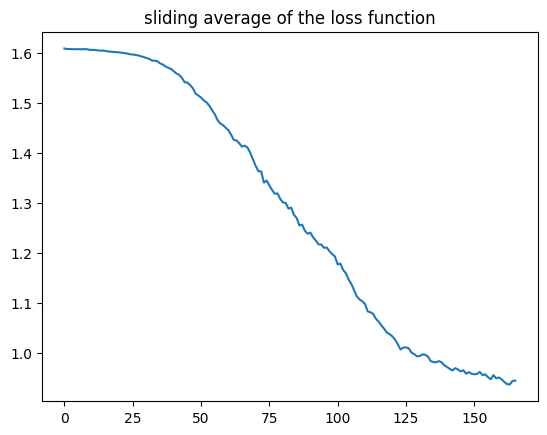

In [ ]:
#plot sliding average to get a smoother curve
conv = 10
plt.plot(np.convolve(loss_list,np.ones(conv),mode='valid')/conv)
plt.title("sliding average of the loss function")
plt.show()

In [ ]:
# check the accuracy on the training set
outputs = net(train_features)
prediction = torch.argmax(outputs,axis=1)
true_label = torch.argmax(train_label,axis=1)
accuracy = sum([int(prediction[i] == true_label[i]) for i in range(train_size)])/train_size
print("The accuracy on the training set is of :",accuracy)  
print("Predicted labels :",prediction)
print("True labels :",true_label)

The accuracy on the training set is of : 0.98
Predicted labels : tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4])
True labels : tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4])


Now, we'll get the features for the test set and run our network on it. Be sure to have the proper path to the file containing the features generated from the previous code.

In [ ]:
def run_network(test_features):
  """
  Runs the network computed previously on the test set. Saves the result in a file.

  Parameters :
  ------------
  `test_features` : Tensor
  The test set containing the features.

  Returns :
  ------------
  A list of the predictions (one label per subject) for the test set.

  """
  test_pred = torch.argmax(net(test_features), axis=1)
  print(test_pred)
  file_name ='labels_test_heffernan.csv'
  with open(file_name, 'w') as f:
    f.truncate(0)
    f.write('Id,Category\n')
    for i in range(len(test_pred)):
      f.write("{},{}\n".format(i+101,test_pred[i].item()))
    files.download("labels_test_heffernan.csv")
  return test_pred


In [ ]:
test_predictions = run_network(test_features)

tensor([2, 4, 0, 3, 4, 1, 0, 0, 4, 4, 3, 3, 4, 0, 0, 4, 2, 3, 1, 0, 4, 0, 3, 3,
        1, 2, 2, 4, 2, 4, 1, 4, 3, 2, 0, 3, 1, 3, 2, 4, 2, 1, 2, 2, 4, 2, 0, 1,
        1, 1])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Complementary classifications
 
I tried other methods of classifications, whose results weren't quite as good as the machine learning approach. 

## Random Forest Classification

This approach was mentioned in some of the articles, and since we had implemented it in one of the labs, I thought it would be relevant to try it. The accuracy isn't as high as the one with the machine learning approach but stille produces good results.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def run_rfc(train_features, train_label, test_features, validation_features = None, validation_label = None, train_validation = False):
  """
  Finds the best selected parameters for a Random Forest Classifier, fits on the training set then predicts the labels on the test set. A validation set can be used to check the accuracy.
  
  Parameters :
  -------------
  `train_features` : tensor
  the tensor containing the train features
  `train_label` : tensor
  The corresponding labels for the train test.
  `test_features` : tensor
  the tensor containing the test features
  `validation_features `,`validation_label` : tensors, None by default.
  If `train_validation` = True, then this are used to compute the accuracy of the trained Random Forest Classifier.
  `train_validation` : Boolean, False by default.
  If True, then a training-validation set is being used to check the accuracy. If False, no validation is done.

  Returns:
  ------------
  A list of the predictions (one label per subject) for the test set.
  """
  RF=RandomForestClassifier(random_state=0)
  p_grid_RF = {'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

  grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
  grid_RF.fit(train_features, train_label)

  best_params=grid_RF.best_params_
  print("best parameters for the Random Forest Classifier :",best_params)

  best_params=grid_RF.best_params_
  rfc = RandomForestClassifier(n_estimators = 1000, min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"], random_state=0)

  rfc.fit(train_features, train_label)

  if train_validation :
    # Predict classes and obtain posterior probability distribution
    outputs = torch.Tensor(rfc.predict(validation_features))
    prediction = torch.argmax(outputs,axis=1)
    true_label = torch.argmax(validation_label,axis=1)
    accuracy = accuracy_score(true_label, prediction)
    print("accuracy on validation set :",accuracy)  


  y_pred = rfc.predict(test_features)
  y_pred_max = np.argmax(y_pred, axis=1)
  return y_pred_max


In [ ]:
if train_and_validation :
  rfc_test_predictions = run_rfc(train_features, train_label, test_features, validation_features, validation_label, True)
else : 
  rfc_test_predictions = run_rfc(train_features, train_label, test_features)
  
print("rfc test predictions :\n",rfc_test_predictions)

best parameters for the Random Forest Classifier : {'max_features': 'sqrt', 'min_samples_leaf': 2}
rfc test predictions :
 [2 4 0 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 0 4 2 4 1 4 3 2 0 0 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


## K-Nearest Neighbours

Out of curiosity, I wanted to see if it was possible to find clusters. And the results are very close to those that Random Forest outputs.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def run_knn(train_features, train_label, test_features, validation_features = None, validation_label = None, train_validation = False):
  """
  Finds the best selected parameters for a k-Nearest Neighbours Classifier, fits on the training set then predicts the labels on the test set. A validation set can be used to check the accuracy.
  
  Parameters :
  -------------
  `train_features` : tensor
  the tensor containing the train features
  `train_label` : tensor
  The corresponding labels for the train test.
  `test_features` : tensor
  the tensor containing the test features
  `validation_features `,`validation_label` : tensors, None by default.
  If `train_validation` = True, then this are used to compute the accuracy of the trained Random Forest Classifier.
  `train_validation` : Boolean, False by default.
  If True, then a training-validation set is being used to check the accuracy. If False, no validation is done.

  Returns:
  ------------
  A list of the predictions (one label per subject) for the test set.
  """
  p_grid_KNN = {'n_neighbors': [i for i in range(1,10)]}   

  knn = KNeighborsClassifier()
  grid_KNN = GridSearchCV(estimator=knn, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
  grid_KNN.fit(train_features, train_label)

  best_params=grid_KNN.best_params_
  print("The best parameters for KNN are :",best_params)
  # Initialize the KNN model
  knn_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])

  # Fit the model on the training data
  knn_model.fit(train_features, train_label)

  if train_validation:
    # Make predictions on new data
    y_pred = knn_model.predict(validation_features)
    y_pred_max = np.argmax(y_pred, axis=1)
    true_label = torch.argmax(validation_label,axis=1)
    accuracy = accuracy_score(true_label, y_pred_max)
    print("accuracy prediction on the validation set:", accuracy)

  y_pred = knn_model.predict(test_features)
  y_pred_max = np.argmax(y_pred, axis=1)
  return y_pred_max



In [ ]:
if train_and_validation:
  knn_test_predictions = run_knn(train_features, train_label, test_features, validation_features, validation_label, True)
else :
  knn_test_predictions = run_knn(train_features, train_label, test_features)
  
print("knn test predictions :\n", knn_test_predictions)

The best parameters for KNN are : {'n_neighbors': 1}
knn test predictions :
 [1 4 0 3 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 0 4 4 3 3 1 2 2 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 2 4 2 0 1 1 1]
